SEIR MODEL

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [11]:
class SEIR_model_gaussian_age:
    def __init__(self, timesteps, pop_sizes, prop_init_infected, betas, gamma, sigma, alpha, beta_vul, age_dist_params, mobility_factors, age_samples=10000):
        self.T = timesteps
        self.pop_sizes = pop_sizes  # Population sizes for each group
        self.prop_init_infected = prop_init_infected  # Initial proportion of infected
        self.betas = betas  # Base transmission rates
        self.gamma = gamma  # Recovery rate
        self.sigma = sigma  # Rate from exposed to infectious
        self.alpha = alpha  # Age-based vulnerability parameter
        self.beta_vul = beta_vul  # Age-based vulnerability parameter
        self.age_dist_params = age_dist_params  # Mean and std dev of age for each group
        self.mobility_factors = mobility_factors  # Mobility factors for each group, contact frequency
        self.age_samples = age_samples  # To approximate age-based vulnerability

    def vulnerability(self, age):
        return np.exp(self.alpha * age + self.beta_vul)

    def vulnerability_age_simulation(self, grp_idx):
        age_mean, age_sd = self.age_dist_params[grp_idx]
        sampled_ages = np.random.normal(age_mean, age_sd, self.age_samples)
        sampled_vulnerabilities = self.vulnerability(sampled_ages) # for each of the age, calculate vulnerability. 
        return np.mean(sampled_vulnerabilities)

    def adjust_betas(self):
        adj_betas = np.zeros_like(self.betas)
        print(adj_betas)
        for i in range(2):  # assuming two groups
            vul_i = self.vulnerability_age_simulation(i)
            for j in range(2):
                vul_j = self.vulnerability_age_simulation(j)
                # use the vulnerability of the group being infected and the mobility factor of the infecting group
                adj_betas[i, j] = self.betas[i, j] * vul_i * self.mobility_factors[j]
        print(adj_betas)
        return adj_betas


    def simulate(self):
        # Initialize compartments for each group
        S, E, I, R = (np.zeros((2, self.T)) for _ in range(4))  
        
        # initial conditions
        for i in range(2):
            I[i, 0] = int(self.prop_init_infected[i] * self.pop_sizes[i])
            S[i, 0] = self.pop_sizes[i] - I[i, 0]
            # E[i, 0] = 1 / 20000
            # assuming no one is exposed or recovered initially

        # adjusted beta values
        adj_betas = self.adjust_betas()

        epsilon = self.sigma  # rate from exposed to infectious
        gamma1 = self.gamma  # recovery rate
        gamma2 = self.gamma  # secondary recovery rate 
        
        # simulation
        for t in range(1, self.T):
            for i in range(2):  # for each group
                beta_E = adj_betas[i, 0]  # transmission rate due to exposed ind
                beta_I = adj_betas[i, 1]  # Transmission rate due to infected ind
                
                
                new_exposures = (beta_E * E[i, t-1] + beta_I * I[i, t-1]) * S[i, t-1] / self.pop_sizes[i]
                new_infections = epsilon * E[i, t-1]
                new_recoveries = gamma1 * I[i, t-1]
                # update
                S[i, t] = S[i, t-1] - new_exposures
                E[i, t] = E[i, t-1] + new_exposures - new_infections
                I[i, t] = I[i, t-1] + new_infections - new_recoveries
                R[i, t] = R[i, t-1] + new_recoveries

                # no negative values
                S[i, t] = max(S[i, t], 0)
                E[i, t] = max(E[i, t], 0)
                I[i, t] = max(I[i, t], 0)
                R[i, t] = max(R[i, t], 0)

        return S, E, I, R

In [17]:
timesteps = 100
pop_sizes = [1000, 500]
prop_init_infected = [0.1, 0.2]

R0 = 2.4
t_infective = 5.1 + 3.3
gamma = 1/t_infective
beta = R0*gamma 

betas = np.array([[beta, 0.5 * beta], [0.5 * beta, beta]])

sigma = .15
alpha = 0.08
beta_vul = -3
age_dist_params = [(30, 5), (40, 10)]  # Mean and std dev for age distributions
mobility_factors = [1.5, 1]  # Mobility factors for each group

# Initialize and run the model
model = SEIR_model_gaussian_age(timesteps, pop_sizes, prop_init_infected, betas, gamma, sigma, alpha, beta_vul, age_dist_params, mobility_factors)
S, E, I, R = model.simulate()

[[0. 0.]
 [0. 0.]]
[[0.25480901 0.08493634]
 [0.35878786 0.47838382]]


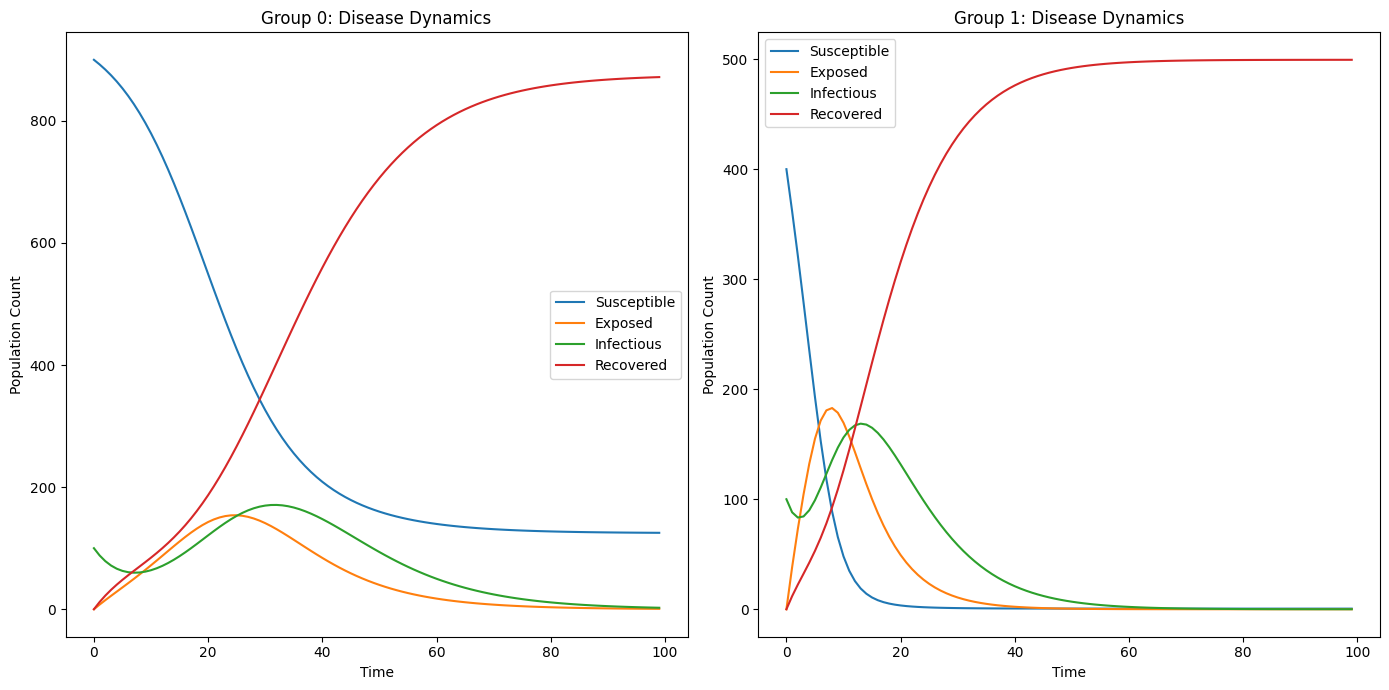

In [18]:
import matplotlib.pyplot as plt

t = np.arange(timesteps)

# Plot for group 0
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # Two subplots for two groups
plt.plot(t, S[0, :], label='Susceptible')
plt.plot(t, E[0, :], label='Exposed')
plt.plot(t, I[0, :], label='Infectious')
plt.plot(t, R[0, :], label='Recovered')
plt.title('Group 0: Disease Dynamics')
plt.xlabel('Time')
plt.ylabel('Population Count')
plt.legend()

# Plot for group 1
plt.subplot(1, 2, 2)
plt.plot(t, S[1, :], label='Susceptible')
plt.plot(t, E[1, :], label='Exposed')
plt.plot(t, I[1, :], label='Infectious')
plt.plot(t, R[1, :], label='Recovered')
plt.title('Group 1: Disease Dynamics')
plt.xlabel('Time')
plt.ylabel('Population Count')
plt.legend()

plt.tight_layout()
plt.show()